In [1]:
# !git clone https://github.com/maziarraissi/PINNs

In [1]:
import sys
import os
import tensorflow as tf
import numpy as np
import tensorflow_probability as tfp

# Manually making sure the numpy random seeds are "the same" on all devices
np.random.seed(1234)
tf.random.set_seed(1234)

In [2]:
import scipy.io
import numpy as np
import tensorflow as tf
import time
from datetime import datetime
from pyDOE import lhs
import os
import sys
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
from scipy.interpolate import griddata
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [3]:
from utils import *

In [4]:
repoPath = os.path.join(".", "PINNs")
utilsPath = os.path.join(repoPath, "Utilities")
dataPath = os.path.join(repoPath, "main", "Data")
appDataPath = os.path.join(repoPath, "appendix", "Data")
sys.path.insert(0, utilsPath)

In [5]:
import time
# Time tracking functions
global_time_list = []
global_last_time = 0
def reset_time():
    global global_time_list, global_last_time
    global_time_list = []
    global_last_time = time.perf_counter()
    
def record_time():
    global global_last_time, global_time_list
    new_time = time.perf_counter()
    global_time_list.append(new_time - global_last_time)
    global_last_time = time.perf_counter()
    #print("step: %.2f"%(global_time_list[-1]*1000))

def last_time():
    """Returns last interval records in millis."""
    global global_last_time, global_time_list
    if global_time_list:
        return 1000 * global_time_list[-1]
    else:
        return 0

---

In [6]:
import tensorflow as tf
import numpy as np

In [7]:
def dot(a, b):
    """Dot product function since TensorFlow doesn't have one."""
    return tf.reduce_sum(a*b)

def verbose_func(s):
    print(s)

In [8]:
def lbfgs(opfunc, x, config, state, do_verbose, log_fn):
    """port of lbfgs.lua, using TensorFlow eager mode.
    """

    if config.maxIter == 0:
        return

    global final_loss, times
    
    maxIter = config.maxIter
    maxEval = config.maxEval or maxIter*1.25
    tolFun = config.tolFun or 1e-5
    tolX = config.tolX or 1e-19
    nCorrection = config.nCorrection or 100
    lineSearch = config.lineSearch
    lineSearchOpts = config.lineSearchOptions
    learningRate = config.learningRate or 1
    isverbose = config.verbose or False

    # verbose function
    if isverbose:
        verbose = verbose_func
    else:
        verbose = lambda x: None

    # evaluate initial f(x) and df/dx
    f, g = opfunc(x)

    f_hist = [f]
    currentFuncEval = 1
    state.funcEval = state.funcEval + 1
    p = g.shape[0]

    # check optimality of initial point
    tmp1 = tf.abs(g)
    if tf.reduce_sum(tmp1) <= tolFun:
        verbose("optimality condition below tolFun")
        return x, f_hist

    # optimize for a max of maxIter iterations
    nIter = 0
    times = []
    while nIter < maxIter:
        start_time = time.time()
        
        # keep track of nb of iterations
        nIter = nIter + 1
        state.nIter = state.nIter + 1

        ############################################################
        ## compute gradient descent direction
        ############################################################
        if state.nIter == 1:
            d = -g
            old_dirs = []
            old_stps = []
            Hdiag = 1
        else:
            # do lbfgs update (update memory)
            y = g - g_old
            s = d*t
            ys = dot(y, s)
            
            if ys > 1e-10:
                # updating memory
                if len(old_dirs) == nCorrection:
                    # shift history by one (limited-memory)
                    del old_dirs[0]
                    del old_stps[0]

                # store new direction/step
                old_dirs.append(s)
                old_stps.append(y)

                # update scale of initial Hessian approximation
                Hdiag = ys/dot(y, y)

            # compute the approximate (L-BFGS) inverse Hessian 
            # multiplied by the gradient
            k = len(old_dirs)

            # need to be accessed element-by-element, so don't re-type tensor:
            ro = [0]*nCorrection
            for i in range(k):
                ro[i] = 1/dot(old_stps[i], old_dirs[i])
                

            # iteration in L-BFGS loop collapsed to use just one buffer
            # need to be accessed element-by-element, so don't re-type tensor:
            al = [0]*nCorrection

            q = -g
            for i in range(k-1, -1, -1):
                al[i] = dot(old_dirs[i], q) * ro[i]
                q = q - al[i]*old_stps[i]

            # multiply by initial Hessian
            r = q*Hdiag
            for i in range(k):
                be_i = dot(old_stps[i], r) * ro[i]
                r += (al[i]-be_i)*old_dirs[i]
                
            d = r
            # final direction is in r/d (same object)

        g_old = g
        f_old = f
        
        ############################################################
        ## compute step length
        ############################################################
        # directional derivative
        gtd = dot(g, d)

        # check that progress can be made along that direction
        if gtd > -tolX:
            verbose("Can not make progress along direction.")
            break

        # reset initial guess for step size
        if state.nIter == 1:
            tmp1 = tf.abs(g)
            t = min(1, 1/tf.reduce_sum(tmp1))
        else:
            t = learningRate


        # optional line search: user function
        lsFuncEval = 0
        if lineSearch and isinstance(lineSearch) == types.FunctionType:
            # perform line search, using user function
            f,g,x,t,lsFuncEval = lineSearch(opfunc,x,t,d,f,g,gtd,lineSearchOpts)
            f_hist.append(f)
        else:
            # no line search, simply move with fixed-step
            x += t*d
            
            if nIter != maxIter:
                # re-evaluate function only if not in last iteration
                # the reason we do this: in a stochastic setting,
                # no use to re-evaluate that function here
                f, g = opfunc(x)
                lsFuncEval = 1
                f_hist.append(f)


        # update func eval
        currentFuncEval = currentFuncEval + lsFuncEval
        state.funcEval = state.funcEval + lsFuncEval

        ############################################################
        ## check conditions
        ############################################################
        if nIter == maxIter:
            break

        if currentFuncEval >= maxEval:
            # max nb of function evals
            verbose('max nb of function evals')
            break

        tmp1 = tf.abs(g)
        if tf.reduce_sum(tmp1) <=tolFun:
            # check optimality
            verbose('optimality condition below tolFun')
            break
        
        tmp1 = tf.abs(d*t)
        if tf.reduce_sum(tmp1) <= tolX:
            # step size below tolX
            verbose('step size below tolX')
            break

        if tf.abs(f-f_old) < tolX:
            # function value changing less than tolX
            verbose('function value changing less than tolX'+str(tf.abs(f-f_old)))
            break

        if do_verbose:
            log_fn(nIter, f.numpy(), True)
            #print("Step %3d loss %6.5f msec %6.3f"%(nIter, f.numpy(), last_time()))
            record_time()
            times.append(last_time())

        if nIter == maxIter - 1:
            final_loss = f.numpy()


    # save state
    state.old_dirs = old_dirs
    state.old_stps = old_stps
    state.Hdiag = Hdiag
    state.g_old = g_old
    state.f_old = f_old
    state.t = t
    state.d = d

    return x, f_hist, currentFuncEval

# dummy/Struct gives Lua-like struct object with 0 defaults
class dummy(object):
    pass

class Struct(dummy):
    def __getattribute__(self, key):
        if key == '__dict__':
            return super(dummy, self).__getattribute__('__dict__')
        return self.__dict__.get(key, 0)

# Continuous inference

$$u_t + u u_x - \nu u_{xx} = 0$$

With $x \in [-1,1],\quad t \in [0,1],\quad \nu = (0.01/\pi)$.

And $u(0,x) = -\sin(\pi x),\quad u(t,-1) = u(t,1) = 0$

Approximating $u(t,x)$ with a deep NN, we define the PINN:
$$f := u_t + u u_x - \nu u_{xx}.$$

We train the shared parameters between the deep NN and the PINN minimizing the loss:
$$MSE =\frac{1}{N_u}\sum_{i=1}^{N_u} |u(t^i_u,x_u^i) - u^i|^2 + \frac{1}{N_f}\sum_{i=1}^{N_f}|f(t_f^i,x_f^i)|^2,$$
with $\{t_u^i, x_u^i, u^i\}_{i=1}^{N_u}$ and $\{t_f^i, x_f^i\}_{i=1}^{N_f}$ respectively the initial/boundary data on $u(t,x)$ and collocations points for $f(t,x)$.

## Hyperparameters

In [9]:
# Data size on the solution u
N_u = 50
# Collocation points size, where we’ll check for f = 0
N_f = 10000
# DeepNN topology (2-sized input [x t], 8 hidden layer of 20-width, 1-sized output [u]
layers = [2, 20, 20, 20, 20, 20, 20, 20, 20, 1]
# Setting up the TF SGD-based optimizer (set tf_epochs=0 to cancel it)
tf_epochs = 100
tf_optimizer = tf.keras.optimizers.Adam(
  learning_rate=0.1,
  beta_1=0.99,
  epsilon=1e-1)
# Setting up the quasi-newton LBGFS optimizer (set nt_epochs=0 to cancel it)
nt_epochs = 2000
nt_config = Struct()
nt_config.learningRate = 0.8
nt_config.maxIter = nt_epochs
nt_config.nCorrection = 50
nt_config.tolFun = 1.0 * np.finfo(float).eps

In [10]:
class PhysicsInformedNN(object):
    def __init__(self, layers, optimizer, logger, X_f, ub, lb, nu):
        # Descriptive Keras model [2, 20, …, 20, 1]
        self.u_model = tf.keras.Sequential()
        self.u_model.add(tf.keras.layers.InputLayer(input_shape=(layers[0],)))
        self.u_model.add(tf.keras.layers.Lambda(
            lambda X: 2.0*(X - lb)/(ub - lb) - 1.0))
        for width in layers[1:]:
            self.u_model.add(tf.keras.layers.Dense(
                width, activation=tf.nn.tanh,
                kernel_initializer='glorot_normal'))

        # Computing the sizes of weights/biases for future decomposition
        self.sizes_w = []
        self.sizes_b = []
        for i, width in enumerate(layers):
            if i != 1:
                self.sizes_w.append(int(width * layers[1]))
                self.sizes_b.append(int(width if i != 0 else layers[1]))

        self.nu = nu
        self.optimizer = optimizer
        self.logger = logger

        self.dtype = tf.float32

        # Separating the collocation coordinates
        self.x_f = tf.convert_to_tensor(X_f[:, 0:1], dtype=self.dtype)
        self.t_f = tf.convert_to_tensor(X_f[:, 1:2], dtype=self.dtype)
        
    # Defining custom loss
    def __loss(self, u, u_pred):
        f_pred = self.f_model()
        return tf.reduce_mean(tf.square(u - u_pred)) + \
            tf.reduce_mean(tf.square(f_pred))

    def __grad(self, X, u):
        with tf.GradientTape() as tape:
            loss_value = self.__loss(u, self.u_model(X))
        return loss_value, tape.gradient(loss_value, self.__wrap_training_variables())

    def __wrap_training_variables(self):
        var = self.u_model.trainable_variables
        return var

    # The actual PINN
    def f_model(self):
        # Using the new GradientTape paradigm of TF2.0,
        # which keeps track of operations to get the gradient at runtime
        with tf.GradientTape(persistent=True) as tape:
            # Watching the two inputs we’ll need later, x and t
            tape.watch(self.x_f)
            tape.watch(self.t_f)
            # Packing together the inputs
            X_f = tf.stack([self.x_f[:,0], self.t_f[:,0]], axis=1)

            # Getting the prediction
            u = self.u_model(X_f)
            # Deriving INSIDE the tape (since we’ll need the x derivative of this later, u_xx)
            u_x = tape.gradient(u, self.x_f)
        
        # Getting the other derivatives
        u_xx = tape.gradient(u_x, self.x_f)
        u_t = tape.gradient(u, self.t_f)

        # Letting the tape go
        del tape

        nu = self.get_params(numpy=True)

        # Buidling the PINNs
        return u_t + u*u_x - nu*u_xx

    def get_params(self, numpy=False):
        return self.nu

    def get_weights(self):
        w = []
        for layer in self.u_model.layers[1:]:
            weights_biases = layer.get_weights()
            weights = weights_biases[0].flatten()
            biases = weights_biases[1]
            w.extend(weights)
            w.extend(biases)
        return tf.convert_to_tensor(w, dtype=self.dtype)

    def set_weights(self, w):
        for i, layer in enumerate(self.u_model.layers[1:]):
            start_weights = sum(self.sizes_w[:i]) + sum(self.sizes_b[:i])
            end_weights = sum(self.sizes_w[:i+1]) + sum(self.sizes_b[:i])
            weights = w[start_weights:end_weights]
            w_div = int(self.sizes_w[i] / self.sizes_b[i])
            weights = tf.reshape(weights, [w_div, self.sizes_b[i]])
            biases = w[end_weights:end_weights + self.sizes_b[i]]
            weights_biases = [weights, biases]
            layer.set_weights(weights_biases)

    def summary(self):
        return self.u_model.summary()

    # The training function
    def fit(self, X_u, u, tf_epochs=5000, nt_config=Struct()):
        self.logger.log_train_start(self)

        # Creating the tensors
        X_u = tf.convert_to_tensor(X_u, dtype=self.dtype)
        u = tf.convert_to_tensor(u, dtype=self.dtype)

        self.logger.log_train_opt("Adam")
        for epoch in range(tf_epochs):
            # Optimization step
            loss_value, grads = self.__grad(X_u, u)
            self.optimizer.apply_gradients(zip(grads, self.__wrap_training_variables()))
            self.logger.log_train_epoch(epoch, loss_value)
        
        self.logger.log_train_opt("LBFGS")
        def loss_and_flat_grad(w):
            with tf.GradientTape() as tape:
                self.set_weights(w)
                loss_value = self.__loss(u, self.u_model(X_u))
            grad = tape.gradient(loss_value, self.u_model.trainable_variables)
            grad_flat = []
            for g in grad:
                grad_flat.append(tf.reshape(g, [-1]))
            grad_flat =  tf.concat(grad_flat, 0)
            return loss_value, grad_flat
        # tfp.optimizer.lbfgs_minimize(
        #   loss_and_flat_grad,
        #   initial_position=self.get_weights(),
        #   num_correction_pairs=nt_config.nCorrection,
        #   max_iterations=nt_config.maxIter,
        #   f_relative_tolerance=nt_config.tolFun,
        #   tolerance=nt_config.tolFun,
        #   parallel_iterations=6)
        lbfgs(loss_and_flat_grad,
            self.get_weights(),
            nt_config, Struct(), True,
            lambda epoch, loss, is_iter:
                self.logger.log_train_epoch(epoch, loss, "", is_iter))

        self.logger.log_train_end(tf_epochs + nt_config.maxIter)

    def predict(self, X_star):
        u_star = self.u_model(X_star)
        f_star = self.f_model()
        return u_star, f_star

In [11]:
# Getting the data
path = os.path.join(appDataPath, "burgers_shock.mat")
x, t, X, T, Exact_u, X_star, u_star, X_u_train, u_train, X_f, ub, lb = prep_data(path, N_u, N_f, noise=0.0)

# Creating the model and training
logger = Logger(frequency=10)
pinn = PhysicsInformedNN(layers, tf_optimizer, logger, X_f, ub, lb, nu=0.01/np.pi)
def error():
    u_pred, _ = pinn.predict(X_star)
    return np.linalg.norm(u_star - u_pred, 2) / np.linalg.norm(u_star, 2)

TensorFlow version: 2.9.2
Eager execution: True
Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
GPU-accerelated: True


2023-11-22 05:41:12.988411: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-22 05:41:13.020994: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:961] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-11-22 05:41:13.028208: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:961] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-11-22 05:41:13.028483: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:961] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built witho

In [ ]:
logger.set_error_fn(error)
pinn.fit(X_u_train, u_train, tf_epochs, nt_config)

# Getting the model predictions, from the same (x,t) that the predictions were previously gotten from
u_pred, f_pred = pinn.predict(X_star)

In [ ]:
plot_inf_cont_results(X_star, u_pred.numpy().flatten(), X_u_train, u_train,Exact_u, X, T, x, t, file="cont_example1")

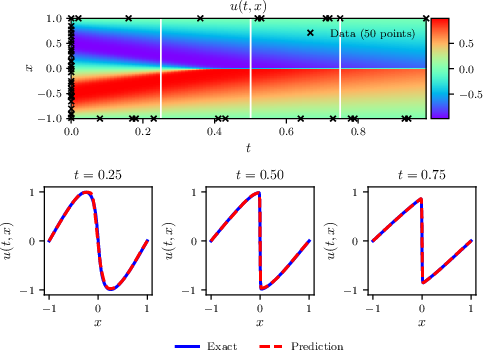

# 2. Discrete Inference
$$u_t + uu_x - \nu u_{xx} = 0$$

With $x \in [-1,1],\quad t \in [0,1],\quad \nu = (0.01/\pi)$.

And $u(0,x) = -\sin(\pi x),\quad u(t,-1) = u(t,1) = 0$

Approximating $u(t,x)$ with a deep NN, we define the PINN: (TODO)
$$f := u_t + u u_x - \nu u_{xx}.$$

We train the shared parameters between the deep NN and the PINN minimizing the loss: (TODO)
$$MSE =\frac{1}{N_u}\sum_{i=1}^{N_u} |u(t^i_u,x_u^i) - u^i|^2 + \frac{1}{N_f}\sum_{i=1}^{N_f}|f(t_f^i,x_f^i)|^2,$$
with $\{t_u^i, x_u^i, u^i\}_{i=1}^{N_u}$ and $\{t_f^i, x_f^i\}_{i=1}^{N_f}$ respectively the initial/boundary data on $u(t,x)$ and collocations points for $f(t,x)$.

## Hyperparameters

In [12]:

# Data size on initial condition on u
N_n = 250
# Number of RK stages
q = 500
# DeepNN topology (1-sized input [x], 3 hidden layer of 50-width, q+1-sized output [u_1^n(x), ..., u_{q+1}^n(x)]
layers = [1, 50, 50, 50, q + 1]
# Setting up the TF SGD-based optimizer (set tf_epochs=0 to cancel it)
tf_epochs = 200
tf_optimizer = tf.keras.optimizers.Adam(
  lr=0.001,
  beta_1=0.9,
  beta_2=0.999,
  epsilon=1e-08)
# Setting up the quasi-newton LBGFS optimizer (set nt_epochs=0 to cancel it)
nt_epochs = 1000
nt_config = Struct()
nt_config.learningRate = 0.8
nt_config.maxIter = nt_epochs
nt_config.nCorrection = 50
nt_config.tolFun = 1.0 * np.finfo(float).eps

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [13]:
class PhysicsInformedNN(object):
    def __init__(self, layers, optimizer, logger, dt, x_1, lb, ub, nu, q, IRK_weights, IRK_times):
        self.lb = lb
        self.ub = ub
        self.nu = nu

        self.dt = dt

        self.q = max(q,1)
        self.IRK_weights = IRK_weights
        self.IRK_times = IRK_times

        # Descriptive Keras model [2, 50, …, 50, q+1]
        self.U_1_model = tf.keras.Sequential()
        self.U_1_model.add(tf.keras.layers.InputLayer(input_shape=(layers[0],)))
        # Normalize
        self.U_1_model.add(tf.keras.layers.Lambda(
          lambda X: 2.0*(X - lb)/(ub - lb) - 1.0))
        for width in layers[1:]:
            self.U_1_model.add(tf.keras.layers.Dense(
              width, activation=tf.nn.tanh,
              kernel_initializer='glorot_normal'))

        # Computing the sizes of weights/biases for future decomposition
        self.sizes_w = []
        self.sizes_b = []
        for i, width in enumerate(layers):
          if i != 1:
            self.sizes_w.append(int(width * layers[1]))
            self.sizes_b.append(int(width if i != 0 else layers[1]))

        self.dtype = tf.float32

        self.x_1 = tf.convert_to_tensor(x_1, dtype=self.dtype)

        self.optimizer = optimizer
        self.logger = logger

    def U_0_model(self, x):
        # Using the new GradientTape paradigm of TF2.0,
        # which keeps track of operations to get the gradient at runtime
        with tf.GradientTape(persistent=True) as tape:
          # Watching the two inputs we’ll need later, x and t
          tape.watch(x)
          tape.watch(self.dummy_x0_tf)

          # Getting the prediction, and removing the last item (q+1)
          U_1 = self.U_1_model(x) # shape=(len(x), q+1)
          U = U_1[:, :-1] # shape=(len(x), q)

          # Deriving INSIDE the tape (2-step-dummy grad technique because U is a mat)
          g_U = tape.gradient(U, x, output_gradients=self.dummy_x0_tf)
          U_x = tape.gradient(g_U, self.dummy_x0_tf)
          g_U_x = tape.gradient(U_x, x, output_gradients=self.dummy_x0_tf)
        
        # Doing the last one outside the with, to optimize performance
        # Impossible to do for the earlier grad, because they’re needed after
        U_xx = tape.gradient(g_U_x, self.dummy_x0_tf)

        # Letting the tape go
        del tape

        # Buidling the PINNs, shape = (len(x), q+1), IRK shape = (q, q+1)
        nu = self.get_params(numpy=True)
        N = U*U_x - nu*U_xx # shape=(len(x), q)
        return U_1 + self.dt*tf.matmul(N, self.IRK_weights.T)

    # Defining custom loss
    def __loss(self, u_0, u_0_pred):
        u_1_pred = self.U_1_model(self.x_1)
        return tf.reduce_sum(tf.square(u_0_pred - u_0)) + \
          tf.reduce_sum(tf.square(u_1_pred))

    def __grad(self, x_0, u_0):
        with tf.GradientTape() as tape:
          loss_value = self.__loss(u_0, self.U_0_model(x_0))
        return loss_value, tape.gradient(loss_value, self.__wrap_training_variables())

    def __wrap_training_variables(self):
        var = self.U_1_model.trainable_variables
        return var

    def get_weights(self):
        w = []
        for layer in self.U_1_model.layers[1:]:
          weights_biases = layer.get_weights()
          weights = weights_biases[0].flatten()
          biases = weights_biases[1]
          w.extend(weights)
          w.extend(biases)
        return tf.convert_to_tensor(w, dtype=self.dtype)

    def set_weights(self, w):
        for i, layer in enumerate(self.U_1_model.layers[1:]):
          start_weights = sum(self.sizes_w[:i]) + sum(self.sizes_b[:i])
          end_weights = sum(self.sizes_w[:i+1]) + sum(self.sizes_b[:i])
          weights = w[start_weights:end_weights]
          w_div = int(self.sizes_w[i] / self.sizes_b[i])
          weights = tf.reshape(weights, [w_div, self.sizes_b[i]])
          biases = w[end_weights:end_weights + self.sizes_b[i]]
          weights_biases = [weights, biases]
          layer.set_weights(weights_biases)

    def get_params(self, numpy=False):
        return self.nu

    def summary(self):
        return self.U_1_model.summary()

    # The training function
    def fit(self, x_0, u_0, tf_epochs, nt_config):
        self.logger.log_train_start(self)

        # Creating the tensors
        x_0 = tf.convert_to_tensor(x_0, dtype=self.dtype)
        u_0 = tf.convert_to_tensor(u_0, dtype=self.dtype)

        # Creating dummy tensors for the gradients
        self.dummy_x0_tf = tf.ones([x_0.shape[0], self.q], dtype=self.dtype)

        self.logger.log_train_opt("Adam")
        for epoch in range(tf_epochs):
          # Optimization step
          loss_value, grads = self.__grad(x_0, u_0)
          self.optimizer.apply_gradients(
            zip(grads, self.__wrap_training_variables()))
          self.logger.log_train_epoch(epoch, loss_value)

        self.logger.log_train_opt("LBFGS")
        def loss_and_flat_grad(w):
          with tf.GradientTape() as tape:
            self.set_weights(w)
            loss_value = self.__loss(u_0, self.U_0_model(x_0))
          grad = tape.gradient(loss_value, self.U_1_model.trainable_variables)
          grad_flat = []
          for g in grad:
            grad_flat.append(tf.reshape(g, [-1]))
          grad_flat =  tf.concat(grad_flat, 0)
          return loss_value, grad_flat
        # tfp.optimizer.lbfgs_minimize(
        #   loss_and_flat_grad,
        #   initial_position=self.get_weights(),
        #   num_correction_pairs=nt_config.nCorrection,
        #   max_iterations=nt_config.maxIter,
        #   f_relative_tolerance=nt_config.tolFun,
        #   tolerance=nt_config.tolFun,
        #   parallel_iterations=6)
        lbfgs(loss_and_flat_grad,
          self.get_weights(),
          nt_config, Struct(), True,
          lambda epoch, loss, is_iter:
            self.logger.log_train_epoch(epoch, loss, "", is_iter))
        
        self.logger.log_train_end(tf_epochs)

    def predict(self, x_star):
        u_star = self.U_1_model(x_star)[:, -1]
        return u_star

In [14]:
# Setup
lb = np.array([-1.0])
ub = np.array([1.0])
idx_t_0 = 10
idx_t_1 = 90
nu = 0.01/np.pi

# Getting the data
path = os.path.join(appDataPath, "burgers_shock.mat")
x, t, dt, \
  Exact_u, x_0, u_0, x_1, x_star, u_star, \
  IRK_weights, IRK_times = prep_data(path, N_n=N_n, q=q, lb=lb, ub=ub, noise=0.0, idx_t_0=idx_t_0, idx_t_1=idx_t_1)

# Creating the model and training
logger = Logger(frequency=10)
pinn = PhysicsInformedNN(layers, tf_optimizer, logger, dt, x_1, lb, ub, nu, q, IRK_weights, IRK_times)
def error():
    u_pred = pinn.predict(x_star)
    return np.linalg.norm(u_pred - u_star, 2) / np.linalg.norm(u_star, 2)
logger.set_error_fn(error)
pinn.fit(x_0, u_0, tf_epochs, nt_config)

# Getting the model predictions, from the same (x,t) that the predictions were previously gotten from
u_1_pred = pinn.predict(x_star)

# Getting the model predictions, from the same (x,t) that the predictions were previously gotten from
u_1_pred = pinn.predict(x_star)

TensorFlow version: 2.9.2
Eager execution: True
GPU-accerelated: True

Training started
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda_1 (Lambda)           (None, 1)                 0         
                                                                 
 dense_9 (Dense)             (None, 50)                100       
                                                                 
 dense_10 (Dense)            (None, 50)                2550      
                                                                 
 dense_11 (Dense)            (None, 50)                2550      
                                                                 
 dense_12 (Dense)            (None, 501)               25551     
                                                                 
Total params: 30,751
Trainable params: 30,751
Non-trainable params: 0
____________________________

2023-11-22 05:41:24.557602: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:961] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-11-22 05:41:24.558203: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:961] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-11-22 05:41:24.558518: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:961] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-11-22 05:41:24.558888: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:961] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-11-22 05:41:24.558902: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Could not ident

2023-11-22 05:41:26.064462: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


tf_epoch =      0  elapsed = 00:02  loss = 6.1188e+04  error = 9.9184e-01  
tf_epoch =     10  elapsed = 00:02  loss = 5.3000e+04  error = 9.1167e-01  
tf_epoch =     20  elapsed = 00:02  loss = 4.0422e+04  error = 8.3942e-01  
tf_epoch =     30  elapsed = 00:03  loss = 3.0798e+04  error = 1.0075e+00  
tf_epoch =     40  elapsed = 00:03  loss = 2.6586e+04  error = 1.2057e+00  
tf_epoch =     50  elapsed = 00:04  loss = 2.3990e+04  error = 1.3010e+00  
tf_epoch =     60  elapsed = 00:04  loss = 2.1986e+04  error = 1.3448e+00  
tf_epoch =     70  elapsed = 00:05  loss = 2.0261e+04  error = 1.3669e+00  
tf_epoch =     80  elapsed = 00:05  loss = 1.8732e+04  error = 1.3788e+00  
tf_epoch =     90  elapsed = 00:05  loss = 1.7443e+04  error = 1.3852e+00  
tf_epoch =    100  elapsed = 00:06  loss = 1.6429e+04  error = 1.3889e+00  
tf_epoch =    110  elapsed = 00:06  loss = 1.5687e+04  error = 1.3913e+00  
tf_epoch =    120  elapsed = 00:07  loss = 1.5193e+04  error = 1.3929e+00  
tf_epoch =  

In [15]:
plot_inf_disc_results(x_star, idx_t_0, idx_t_1, x_0, u_0, ub, lb, u_1_pred, Exact_u, x, t, file="disc_example1")

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


# 3. Continuous Identification

$$u_t + \lambda_1 u u_x - \lambda_2 u_{xx} = 0$$

With $\lambda_1$ and $\lambda_2$ real parameters of the differential operator.

Approximating $u(t,x)$ with a deep NN, we define the PINN:
$$f := u_t + \lambda_1 u u_x - \lambda_2 u_{xx}.$$

We train the shared parameters between the deep NN and the PINN minimizing the loss:
$$MSE =\frac{1}{N_u}\sum_{i=1}^{N_u} |u(t^i_u,x_u^i) - u^i|^2 + \frac{1}{N_f}\sum_{i=1}^{N_u}|f(t_u^i,x_u^i)|^2,$$
with $\{t_u^i, x_u^i, u^i\}_{i=1}^{N_u}$ respectively the trainring data on $u(t,x)$.

In [17]:
# Data size on the solution u
N_u = 2000
# DeepNN topology (2-sized input [x t], 8 hidden layer of 20-width, 1-sized output [u]
layers = [2, 20, 20, 20, 20, 20, 20, 20, 20, 1]
# Setting up the TF SGD-based optimizer (set tf_epochs=0 to cancel it)
tf_epochs = 100
tf_optimizer = tf.keras.optimizers.Adam(
  learning_rate=0.001)
# Setting up the quasi-newton LBGFS optimizer (set nt_epochs=0 to cancel it)
nt_epochs = 1000
nt_config = Struct()
nt_config.learningRate = 0.8
nt_config.maxIter = nt_epochs
nt_config.nCorrection = 50
nt_config.tolFun = 1.0 * np.finfo(float).eps

In [18]:
class PhysicsInformedNN(object):
  def __init__(self, layers, optimizer, logger, ub, lb):
    # Descriptive Keras model [2, 20, …, 20, 1]
    self.u_model = tf.keras.Sequential()
    self.u_model.add(tf.keras.layers.InputLayer(input_shape=(layers[0],)))
    self.u_model.add(tf.keras.layers.Lambda(
      lambda X: 2.0*(X - lb)/(ub - lb) - 1.0))
    for width in layers[1:]:
        self.u_model.add(tf.keras.layers.Dense(
          width, activation=tf.nn.tanh,
          kernel_initializer='glorot_normal'))

    # Computing the sizes of weights/biases for future decomposition
    self.sizes_w = []
    self.sizes_b = []
    for i, width in enumerate(layers):
      if i != 1:
        self.sizes_w.append(int(width * layers[1]))
        self.sizes_b.append(int(width if i != 0 else layers[1]))

    self.dtype = tf.float32

    # Defining the two additional trainable variables for identification
    self.lambda_1 = tf.Variable([0.0], dtype=self.dtype)
    self.lambda_2 = tf.Variable([-6.0], dtype=self.dtype)
    
    self.optimizer = optimizer
    self.logger = logger

  # The actual PINN
  def __f_model(self, X_u):
    l1, l2 = self.get_params()
    # Separating the collocation coordinates
    x_f = tf.convert_to_tensor(X_u[:, 0:1], dtype=self.dtype)
    t_f = tf.convert_to_tensor(X_u[:, 1:2], dtype=self.dtype)

    # Using the new GradientTape paradigm of TF2.0,
    # which keeps track of operations to get the gradient at runtime
    with tf.GradientTape(persistent=True) as tape:
      # Watching the two inputs we’ll need later, x and t
      tape.watch(x_f)
      tape.watch(t_f)
      # Packing together the inputs
      X_f = tf.stack([x_f[:,0], t_f[:,0]], axis=1)


      # Getting the prediction
      u = self.u_model(X_f)
      # Deriving INSIDE the tape (since we’ll need the x derivative of this later, u_xx)
      u_x = tape.gradient(u, x_f)
    
    # Getting the other derivatives
    u_xx = tape.gradient(u_x, x_f)
    u_t = tape.gradient(u, t_f)

    # Letting the tape go
    del tape

    # Buidling the PINNs
    return u_t + l1*u*u_x - l2*u_xx

  # Defining custom loss
  def __loss(self, X_u, u, u_pred):
    f_pred = self.__f_model(X_u)
    return tf.reduce_mean(tf.square(u - u_pred)) + \
      tf.reduce_mean(tf.square(f_pred))

  def __grad(self, X, u):
    with tf.GradientTape() as tape:
      loss_value = self.__loss(X, u, self.u_model(X))
    return loss_value, tape.gradient(loss_value, self.__wrap_training_variables())

  def __wrap_training_variables(self):
    var = self.u_model.trainable_variables
    var.extend([self.lambda_1, self.lambda_2])
    return var

  def get_weights(self):
      w = []
      for layer in self.u_model.layers[1:]:
        weights_biases = layer.get_weights()
        weights = weights_biases[0].flatten()
        biases = weights_biases[1]
        w.extend(weights)
        w.extend(biases)
      w.extend(self.lambda_1.numpy())
      w.extend(self.lambda_2.numpy())
      return tf.convert_to_tensor(w, dtype=self.dtype)

  def set_weights(self, w):
    for i, layer in enumerate(self.u_model.layers[1:]):
      start_weights = sum(self.sizes_w[:i]) + sum(self.sizes_b[:i])
      end_weights = sum(self.sizes_w[:i+1]) + sum(self.sizes_b[:i])
      weights = w[start_weights:end_weights]
      w_div = int(self.sizes_w[i] / self.sizes_b[i])
      weights = tf.reshape(weights, [w_div, self.sizes_b[i]])
      biases = w[end_weights:end_weights + self.sizes_b[i]]
      weights_biases = [weights, biases]
      layer.set_weights(weights_biases)
    self.lambda_1.assign([w[-2]])
    self.lambda_2.assign([w[-1]])

  def get_params(self, numpy=False):
    l1 = self.lambda_1
    l2 = tf.exp(self.lambda_2)
    if numpy:
      return l1.numpy()[0], l2.numpy()[0]
    return l1, l2

  def summary(self):
    return self.u_model.summary()

  # The training function
  def fit(self, X_u, u, tf_epochs, nt_config):
    self.logger.log_train_start(self)

    # Creating the tensors
    X_u = tf.convert_to_tensor(X_u, dtype=self.dtype)
    u = tf.convert_to_tensor(u, dtype=self.dtype)

    def log_train_epoch(epoch, loss, is_iter):
      l1, l2 = self.get_params(numpy=True)
      custom = f"l1 = {l1:5f}  l2 = {l2:8f}"
      self.logger.log_train_epoch(epoch, loss, custom, is_iter)

    self.logger.log_train_opt("Adam")
    for epoch in range(tf_epochs):
      # Optimization step
      loss_value, grads = self.__grad(X_u, u)
      self.optimizer.apply_gradients(
        zip(grads, self.__wrap_training_variables()))
      log_train_epoch(epoch, loss_value, False)

    self.logger.log_train_opt("LBFGS")
    def loss_and_flat_grad(w):
      with tf.GradientTape() as tape:
        self.set_weights(w)
        tape.watch(self.lambda_1)
        tape.watch(self.lambda_2)
        loss_value = self.__loss(X_u, u, self.u_model(X_u))
      grad = tape.gradient(loss_value, self.__wrap_training_variables())
      grad_flat = []
      for g in grad:
        grad_flat.append(tf.reshape(g, [-1]))
      grad_flat =  tf.concat(grad_flat, 0)
      return loss_value, grad_flat
    # tfp.optimizer.lbfgs_minimize(
    #   loss_and_flat_grad,
    #   initial_position=self.get_weights(),
    #   num_correction_pairs=nt_config.nCorrection,
    #   max_iterations=nt_config.maxIter,
    #   f_relative_tolerance=nt_config.tolFun,
    #   tolerance=nt_config.tolFun,
    #   parallel_iterations=6)
    lbfgs(loss_and_flat_grad,
      self.get_weights(),
      nt_config, Struct(), True, log_train_epoch)
    
    l1, l2 = self.get_params(numpy=True)
    self.logger.log_train_end(tf_epochs, f"l1 = {l1:5f}  l2 = {l2:8f}")

  def predict(self, X_star):
    u_star = self.u_model(X_star)
    f_star = self.__f_model(X_star)
    return u_star.numpy(), f_star.numpy()

In [19]:
# Getting the data
path = os.path.join(appDataPath, "burgers_shock.mat")
x, t, X, T, Exact_u, X_star, u_star, \
  X_u_train, u_train, ub, lb = prep_data(path, N_u, noise=0.0)
lambdas_star = (1.0, 0.01/np.pi)

# Creating the model and training
logger = Logger(frequency=10)
pinn = PhysicsInformedNN(layers, tf_optimizer, logger, ub, lb)
def error():
    l1, l2 = pinn.get_params(numpy=True)
    l1_star, l2_star = lambdas_star
    error_lambda_1 = np.abs(l1 - l1_star) / l1_star
    error_lambda_2 = np.abs(l2 - l2_star) / l2_star
    return (error_lambda_1 + error_lambda_2) / 2
logger.set_error_fn(error)
pinn.fit(X_u_train, u_train, tf_epochs, nt_config)

# Getting the model predictions, from the same (x,t) that the predictions were previously gotten from
u_pred, f_pred = pinn.predict(X_star)
lambda_1_pred, lambda_2_pred = pinn.get_params(numpy=True)

# Noise case
x, t, X, T, Exact_u, X_star, u_star, \
  X_u_train, u_train, ub, lb = prep_data(path, N_u, noise=0.01)
pinn = PhysicsInformedNN(layers, tf_optimizer, logger, ub, lb)
pinn.fit(X_u_train, u_train, tf_epochs, nt_config)
lambda_1_pred_noise, lambda_2_pred_noise = pinn.get_params(numpy=True)

print("l1: ", lambda_1_pred)
print("l2: ", lambda_2_pred)
print("l1_noise: ", lambda_1_pred_noise)
print("l2_noise: ", lambda_2_pred_noise)

TensorFlow version: 2.9.2
Eager execution: True
GPU-accerelated: True

Training started
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda_2 (Lambda)           (None, 2)                 0         
                                                                 
 dense_13 (Dense)            (None, 20)                60        
                                                                 
 dense_14 (Dense)            (None, 20)                420       
                                                                 
 dense_15 (Dense)            (None, 20)                420       
                                                                 
 dense_16 (Dense)            (None, 20)                420       
                                                                 
 dense_17 (Dense)            (None, 20)                420       
                                

2023-11-22 06:26:47.842373: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:961] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-11-22 06:26:47.842689: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:961] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-11-22 06:26:47.842917: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:961] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-11-22 06:26:47.843430: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:961] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-11-22 06:26:47.843447: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Could not ident

tf_epoch =      0  elapsed = 00:00  loss = 5.9407e-01  error = 6.1009e-01  l1 = 0.000966  l2 = 0.002479
tf_epoch =     10  elapsed = 00:00  loss = 3.0893e-01  error = 6.0845e-01  l1 = 0.003536  l2 = 0.002481
tf_epoch =     20  elapsed = 00:01  loss = 2.5277e-01  error = 6.1006e-01  l1 = -0.005575  l2 = 0.002500
tf_epoch =     30  elapsed = 00:02  loss = 2.3607e-01  error = 6.1136e-01  l1 = -0.017494  l2 = 0.002530
tf_epoch =     40  elapsed = 00:02  loss = 2.1998e-01  error = 6.1248e-01  l1 = -0.030334  l2 = 0.002564
tf_epoch =     50  elapsed = 00:03  loss = 2.0089e-01  error = 6.1307e-01  l1 = -0.041686  l2 = 0.002596
tf_epoch =     60  elapsed = 00:04  loss = 1.7534e-01  error = 6.1300e-01  l1 = -0.049537  l2 = 0.002621
tf_epoch =     70  elapsed = 00:05  loss = 1.4044e-01  error = 6.1422e-01  l1 = -0.051598  l2 = 0.002620
tf_epoch =     80  elapsed = 00:05  loss = 1.0898e-01  error = 6.1704e-01  l1 = -0.044117  l2 = 0.002578
tf_epoch =     90  elapsed = 00:06  loss = 8.8361e-02  er

In [21]:
plot_ide_cont_results(X_star, u_pred, X_u_train, u_train, Exact_u, X, T, x, t, lambda_1_pred, lambda_1_pred_noise, lambda_2_pred, lambda_2_pred_noise, file="cont_example2")

ValueError: Error measuring \rmfamily\fontsize{10.000000}{12.000000}\selectfont \(\displaystyle \begin{tabular}{ |c|c| }  \hline Correct PDE & \)u_t + u u_x - 0.0031831 u_{xx} = 0\(\displaystyle  \\  \hline Identified PDE (clean data) & \)u_t + -787.71173 u u_x - 206648414996600171207310966784.0000000 u_{xx} = 0\(\displaystyle  \\  \hline Identified PDE (1\% noise) & \)u_t + -648327069696.00000 u u_x - 0.0000000 u_{xx} = 0\(\displaystyle   \\  \hline \end{tabular}\)
LaTeX Output:

! LaTeX Error: Bad math environment delimiter.

See the LaTeX manual or LaTeX Companion for explanation.
Type  H <return>  for immediate help.
 ...                                              
                                                  
<*> ...\displaystyle   \\  \hline \end{tabular}\)}
                                                  \typeout{\the\wd0,\the\ht0...
!  ==> Fatal error occurred, no output PDF file produced!
Transcript written on texput.log.


# 4. Discrete Identification

$$u_t + \lambda_1 u u_x - \lambda_2 u_{xx} = 0$$

With $\lambda_1$ and $\lambda_2$ real parameters of the differential operator.

Approximating $u(t,x)$ with a deep NN, we define the PINN:
$$f := u_t + \lambda_1 u u_x - \lambda_2 u_{xx}.$$

We train the shared parameters between the deep NN and the PINN minimizing the loss:
$$MSE =\frac{1}{N_u}\sum_{i=1}^{N_u} |u(t^i_u,x_u^i) - u^i|^2 + \frac{1}{N_f}\sum_{i=1}^{N_u}|f(t_u^i,x_u^i)|^2,$$
with $\{t_u^i, x_u^i, u^i\}_{i=1}^{N_u}$ respectively the trainring data on $u(t,x)$.

In [9]:
# Data size on initial condition on u
N_0 = 199
N_1 = 201
# DeepNN topology (1-sized input [x], 3 hidden layer of 50-width, q-sized output defined later [u_1^n(x), ..., u_{q+1}^n(x)]
layers = [1, 50, 50, 50, 0]
# Setting up the TF SGD-based optimizer (set tf_epochs=0 to cancel it)
tf_epochs = 100
tf_optimizer = tf.keras.optimizers.Adam(
  lr=0.001,
  beta_1=0.9,
  beta_2=0.999,
  epsilon=1e-08)
# Setting up the quasi-newton LBGFS optimizer (set nt_epochs=0 to cancel it)
nt_epochs = 2000
nt_config = Struct()
nt_config.learningRate = 0.8
nt_config.maxIter = nt_epochs
nt_config.nCorrection = 50
nt_config.tolFun = 1.0 * np.finfo(float).eps

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [10]:

class PhysicsInformedNN(object):
  def __init__(self, layers, optimizer, logger, dt, lb, ub, q, IRK_alpha, IRK_beta):
    self.lb = lb
    self.ub = ub

    self.dt = dt

    self.q = max(q,1)
    self.IRK_alpha = IRK_alpha
    self.IRK_beta = IRK_beta

    # Descriptive Keras model [2, 50, …, 50, q+1]
    self.U_model = tf.keras.Sequential()
    self.U_model.add(tf.keras.layers.InputLayer(input_shape=(layers[0],)))
    self.U_model.add(tf.keras.layers.Lambda(
      lambda X: 2.0*(X - lb)/(ub - lb) - 1.0))
    for width in layers[1:]:
        self.U_model.add(tf.keras.layers.Dense(
          width, activation=tf.nn.tanh,
          kernel_initializer='glorot_normal'))

    # Computing the sizes of weights/biases for future decomposition
    self.sizes_w = []
    self.sizes_b = []
    for i, width in enumerate(layers):
      if i != 1:
        self.sizes_w.append(int(width * layers[1]))
        self.sizes_b.append(int(width if i != 0 else layers[1]))

    self.dtype = tf.float32

    self.optimizer = optimizer
    self.logger = logger

  def __autograd(self, U, x, dummy):
    # Using the new GradientTape paradigm of TF2.0,
    # which keeps track of operations to get the gradient at runtime
    with tf.GradientTape(persistent=True) as tape:
      # Watching the two inputs we’ll need later, x and t
      tape.watch(x)
      tape.watch(dummy)

      # Getting the prediction
      U = self.U_model(x) # shape=(len(x), q)

      # Deriving INSIDE the tape (2-step-dummy grad technique because U is a mat)
      g_U = tape.gradient(U, x, output_gradients=dummy)
      U_x = tape.gradient(g_U, dummy)
      g_U_x = tape.gradient(U_x, x, output_gradients=dummy)
    
    # Doing the last one outside the with, to optimize performance
    # Impossible to do for the earlier grad, because they’re needed after
    U_xx = tape.gradient(g_U_x, dummy)

    # Letting the tape go
    del tape
    return U_x, U_xx

  def U_0_model(self, x, customDummy=None):
    U = self.U_model(x)
    if customDummy != None:
      dummy = customDummy
    else:
      dummy = self.dummy_x_0
    U_x, U_xx = self.__autograd(U, x, dummy)

    # Buidling the PINNs
    l1 = self.lambda_1
    l2 = tf.exp(self.lambda_2)
    N = l1*U*U_x - l2*U_xx # shape=(len(x), q)
    return U + self.dt*tf.matmul(N, self.IRK_alpha.T)

  def U_1_model(self, x, customDummy=None):
    U = self.U_model(x)
    #dummy = customDummy or self.dummy_x_1
    if customDummy != None:
      dummy = customDummy
    else:
      dummy = self.dummy_x_1
    U_x, U_xx = self.__autograd(U, x, dummy)

    # Buidling the PINNs, shape = (len(x), q+1), IRK shape = (q, q+1)
    l1 = self.lambda_1
    l2 = tf.exp(self.lambda_2)
    N = -l1*U*U_x + l2*U_xx # shape=(len(x), q)
    return U + self.dt*tf.matmul(N, (self.IRK_beta - self.IRK_alpha).T)

  # Defining custom loss
  def __loss(self, x_0, u_0, x_1, u_1):
    u_0_pred = self.U_0_model(x_0)
    u_1_pred = self.U_1_model(x_1)
    return tf.reduce_sum(tf.square(u_0_pred - u_0)) + \
      tf.reduce_sum(tf.square(u_1_pred - u_1))

  def __grad(self, x_0, u_0, x_1, u_1):
    with tf.GradientTape() as tape:
      loss_value = self.__loss(x_0, u_0, x_1, u_1)
    return loss_value, tape.gradient(loss_value, self.__wrap_training_variables())

  def __wrap_training_variables(self):
    var = self.U_model.trainable_variables
    var.extend([self.lambda_1, self.lambda_2])
    return var

  def get_weights(self):
      w = []
      for layer in self.U_model.layers[1:]:
        weights_biases = layer.get_weights()
        weights = weights_biases[0].flatten()
        biases = weights_biases[1]
        w.extend(weights)
        w.extend(biases)
      w.extend(self.lambda_1.numpy())
      w.extend(self.lambda_2.numpy())
      return tf.convert_to_tensor(w, dtype=self.dtype)

  def set_weights(self, w):
    for i, layer in enumerate(self.U_model.layers[1:]):
      start_weights = sum(self.sizes_w[:i]) + sum(self.sizes_b[:i])
      end_weights = sum(self.sizes_w[:i+1]) + sum(self.sizes_b[:i])
      weights = w[start_weights:end_weights]
      w_div = int(self.sizes_w[i] / self.sizes_b[i])
      weights = tf.reshape(weights, [w_div, self.sizes_b[i]])
      biases = w[end_weights:end_weights + self.sizes_b[i]]
      weights_biases = [weights, biases]
      layer.set_weights(weights_biases)
    self.lambda_1.assign([w[-2]])
    self.lambda_2.assign([w[-1]])

  def get_params(self, numpy=False):
    l1 = self.lambda_1
    l2 = tf.exp(self.lambda_2)
    if numpy:
      return l1.numpy()[0], l2.numpy()[0]
    return l1, l2

  def summary(self):
    return self.U_model.summary()

  def __createDummy(self, x):
    return tf.ones([x.shape[0], self.q], dtype=self.dtype)

  # The training function
  def fit(self, x_0, u_0, x_1, u_1, tf_epochs=1):
    self.logger.log_train_start(self)

    # Creating the tensors
    x_0 = tf.convert_to_tensor(x_0, dtype=self.dtype)
    u_0 = tf.convert_to_tensor(u_0, dtype=self.dtype)
    x_1 = tf.convert_to_tensor(x_1, dtype=self.dtype)
    u_1 = tf.convert_to_tensor(u_1, dtype=self.dtype)

    self.lambda_1 = tf.Variable([0.0], dtype=self.dtype)
    self.lambda_2 = tf.Variable([-6.0], dtype=self.dtype)

    # Creating dummy tensors for the gradients
    self.dummy_x_0 = self.__createDummy(x_0)
    self.dummy_x_1 = self.__createDummy(x_1)

    def log_train_epoch(epoch, loss, is_iter):
      l1, l2 = self.get_params(numpy=True)
      custom = f"l1 = {l1:5f}  l2 = {l2:8f}"
      self.logger.log_train_epoch(epoch, loss, custom, is_iter)

    self.logger.log_train_opt("Adam")
    for epoch in range(tf_epochs):
      # Optimization step
      loss_value, grads = self.__grad(x_0, u_0, x_1, u_1)
      self.optimizer.apply_gradients(
        zip(grads, self.__wrap_training_variables()))
      log_train_epoch(epoch, loss_value, False)
    
    self.logger.log_train_opt("LBFGS")
    def loss_and_flat_grad(w):
      with tf.GradientTape() as tape:
        self.set_weights(w)
        tape.watch(self.lambda_1)
        tape.watch(self.lambda_2)
        loss_value = self.__loss(x_0, u_0, x_1, u_1)
      grad = tape.gradient(loss_value, self.__wrap_training_variables())
      grad_flat = []
      for g in grad:
        grad_flat.append(tf.reshape(g, [-1]))
      grad_flat =  tf.concat(grad_flat, 0)
      return loss_value, grad_flat
    # tfp.optimizer.lbfgs_minimize(
    #   loss_and_flat_grad,
    #   initial_position=self.get_weights(),
    #   num_correction_pairs=nt_config.nCorrection,
    #   max_iterations=nt_config.maxIter,
    #   f_relative_tolerance=nt_config.tolFun,
    #   tolerance=nt_config.tolFun,
    #   parallel_iterations=6)
    lbfgs(loss_and_flat_grad,
      self.get_weights(),
      nt_config, Struct(), True, log_train_epoch)
    
    l1, l2 = self.get_params(numpy=True)
    self.logger.log_train_end(tf_epochs, f"l1 = {l1:5f}  l2 = {l2:8f}")

  def predict(self, x_star):
    x_star = tf.convert_to_tensor(x_star, dtype=self.dtype)
    dummy = self.__createDummy(x_star)
    U_0_star = self.U_0_model(x_star, dummy)
    U_1_star = self.U_1_model(x_star, dummy)
    return U_0_star, U_1_star

In [11]:
# Setup
lb = np.array([-1.0])
ub = np.array([1.0])
idx_t_0 = 10
skip = 80
idx_t_1 = idx_t_0 + skip

# Getting the data
path = os.path.join(appDataPath, "burgers_shock.mat")
x_0, u_0, x_1, u_1, x_star, t_star, dt, q, \
  Exact_u, IRK_alpha, IRK_beta = prep_data(path, N_0=N_0, N_1=N_1,
  lb=lb, ub=ub, noise=0.0, idx_t_0=idx_t_0, idx_t_1=idx_t_1)
lambdas_star = (1.0, 0.01/np.pi)

# Setting the output layer dynamically
layers[-1] = q
 
# Creating the model and training
logger = Logger(frequency=10)
pinn = PhysicsInformedNN(layers, tf_optimizer, logger, dt, lb, ub, q, IRK_alpha, IRK_beta)
def error():
  l1, l2 = pinn.get_params(numpy=True)
  l1_star, l2_star = lambdas_star
  error_lambda_1 = np.abs(l1 - l1_star) / l1_star
  error_lambda_2 = np.abs(l2 - l2_star) / l2_star
  return (error_lambda_1 + error_lambda_2) / 2
logger.set_error_fn(error)
pinn.fit(x_0, u_0, x_1, u_1, tf_epochs)

# Getting the model predictions
U_0_pred, U_1_pred = pinn.predict(x_star)
lambda_1_pred, lambda_2_pred = pinn.get_params(numpy=True)

# Noisy case (same as before with a different noise)
x_0, u_0, x_1, u_1, x_star, t_star, dt, q, \
  Exact_u, IRK_alpha, IRK_beta = prep_data(path, N_0=N_0, N_1=N_1,
  lb=lb, ub=ub, noise=0.01, idx_t_0=idx_t_0, idx_t_1=idx_t_1)
layers[-1] = q
pinn = PhysicsInformedNN(layers, tf_optimizer, logger, dt, lb, ub, q, IRK_alpha, IRK_beta)
pinn.fit(x_0, u_0, x_1, u_1, tf_epochs)
U_0_pred, U_1_pred = pinn.predict(x_star)
lambda_1_pred_noisy, lambda_2_pred_noisy = pinn.get_params(numpy=True)

print("l1: ", lambda_1_pred)
print("l2: ", lambda_2_pred)
print("noisy l1: ", lambda_1_pred_noisy)
print("noisy l2: ", lambda_2_pred_noisy)

TensorFlow version: 2.9.2
Eager execution: True
Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
GPU-accerelated: True

Training started
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda (Lambda)             (None, 1)                 0         
                                                                 
 dense (Dense)               (None, 50)                100       
                                                                 
 dense_1 (Dense)             (None, 50)                2550      
                                                                 
 dense_2 (Dense)             (None, 50)                2550      
                                                                 
 dense_3 (Dense)             (None, 81)                4131      
                                                                 
Total params: 9,331

2023-11-22 06:59:30.520025: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-22 06:59:30.544831: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:961] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-11-22 06:59:30.552483: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:961] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-11-22 06:59:30.552732: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:961] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built witho

None
—— Starting Adam optimization ——


2023-11-22 06:59:31.950200: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


tf_epoch =      0  elapsed = 00:01  loss = 1.1932e+04  error = 6.1075e-01  l1 = -0.001000  l2 = 0.002481
tf_epoch =     10  elapsed = 00:01  loss = 9.6115e+03  error = 6.1174e-01  l1 = -0.010920  l2 = 0.002506
tf_epoch =     20  elapsed = 00:02  loss = 7.6302e+03  error = 6.1292e-01  l1 = -0.021914  l2 = 0.002534
tf_epoch =     30  elapsed = 00:03  loss = 6.3343e+03  error = 6.1419e-01  l1 = -0.034379  l2 = 0.002566
tf_epoch =     40  elapsed = 00:04  loss = 5.8713e+03  error = 6.1537e-01  l1 = -0.047966  l2 = 0.002601
tf_epoch =     50  elapsed = 00:05  loss = 5.5221e+03  error = 6.1626e-01  l1 = -0.061451  l2 = 0.002639
tf_epoch =     60  elapsed = 00:06  loss = 5.1174e+03  error = 6.1662e-01  l1 = -0.073660  l2 = 0.002675
tf_epoch =     70  elapsed = 00:07  loss = 4.6041e+03  error = 6.1623e-01  l1 = -0.083915  l2 = 0.002710
tf_epoch =     80  elapsed = 00:08  loss = 4.0219e+03  error = 6.1506e-01  l1 = -0.091490  l2 = 0.002742
tf_epoch =     90  elapsed = 00:08  loss = 3.4808e+03  

In [23]:
plot_ide_disc_results(x_star, t_star, idx_t_0, idx_t_1, x_0, u_0, x_1, u_1,
  ub, lb, U_1_pred, Exact_u, lambda_1_pred, lambda_1_pred_noisy, lambda_2_pred, lambda_2_pred_noisy, x_star, t_star, file="disc_example2")

/tmp/ipykernel_2117/3589832593.py:10: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(gs0[:, :])
